In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student'
}

# Таблица default.retail

* InvoiceNo – уникальный id чека
* StockCode – Бог его знает, что это за id, использовать не будем
* Description – описание товара
* Quantity – уникальный id чека
* InvoiceDate – дата-время покупки 
* UnitPrice – цена единицы товара
* CustomerID – уникальный id покупателя
* Country – Страна

## Задача 1

Найти CustomerID, которые за февраль-март купили наибольшее количество товаров (суммарное Quantity) в англоговорящих странах, о которых у нас есть информация. Если, например, в США два покупателя купили по 100 товаров, а остальные меньше – вывести обоих.

Ожидаемый ответ:

Страна – CustomerID - Кол-во товара, которое он купил за февраль-март

## Задача 2

Вывести помесячное количество купленных будильников (в описании товара должно быть ALARM, ALARM CLOCK. Может быть еще какое-то обозначение, если найдете, будет круто :))

## Задача 3

Какой товар (какие товары, если таких с максимальной ценой несколько) в таблице является самым дорогим? Вывести id товаров и их описание.

## Задача 4

Из какой страны было больше всего покупателей?

## Задача 1

In [3]:
q = '''
with 
    toDate(InvoiceDate) as dt,
    tuple('United Kingdom', 'Australia', 'EIRE', 'Channel Islands',
        'Canada', 'Malta', 'USA', 'European Community') as english,
    a as (  select
                Country,
                CustomerID,
                sum(Quantity) as buy
            from default.retail
            where True
                and dt between '2011-02-01' and '2011-03-31'
                and Country in english
            group by Country, CustomerID)

select
    Country,
    CustomerID,
    buy
from a
inner join
(select
    Country,
    max(buy) as max_buy
from a
group by Country) as b
on a.Country = b.Country
where a.buy = b.max_buy
order by buy desc
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,Country,CustomerID,buy
0,Australia,12415,18546
1,United Kingdom,13694,12244
2,EIRE,14156,8026
3,Channel Islands,14936,944
4,Canada,15388,88


## Задача 2

In [4]:
q = '''
SELECT
    --toMonth( InvoiceDate )
    Description
from default.retail
where position(Description, 'ALARM') > 0
    and position(Description, 'CLOCK') = 0
LIMIT 10
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

# Не выдаёт ничего, поэтому ищем только по слову ALARM.

,Description


In [5]:
q = '''
SELECT
    toYear( InvoiceDate ) as year_n,
    toMonth( InvoiceDate ) as month_n,
    sum(Quantity) as buy
from default.retail
where position(Description, 'ALARM') > 0
group by year_n, month_n
order by year_n, month_n
'''

df = pandahouse.read_clickhouse(q, connection=connection)
print(f'Всего будильников: {sum(df.buy)}')
df

Всего будильников: 24483


,year_n,month_n,buy
0,2010,12,1570
1,2011,1,902
2,2011,2,1119
3,2011,3,970
4,2011,4,2633
5,2011,5,888
6,2011,6,1614
7,2011,7,1136
8,2011,8,2922
9,2011,9,2422


## Задача 3

In [6]:
# Не работает в pandahouse. Прикрепляю скрин.

'''
with 
    b as (  select
                max(UnitPrice) as max_price
            from default.retail)

select
    distinct(xxHash64(toString(Description)||'a')) as UnitID,
    Description,
    UnitPrice
from default.retail as a
inner join b
on a.UnitPrice = b.max_price
'''

"\nwith \n    b as (  select\n                max(UnitPrice) as max_price\n            from default.retail)\n\nselect\n    distinct(xxHash64(toString(Description)||'a')) as UnitID,\n    Description,\n    UnitPrice\nfrom default.retail as a\ninner join b\non a.UnitPrice = b.max_price\n"

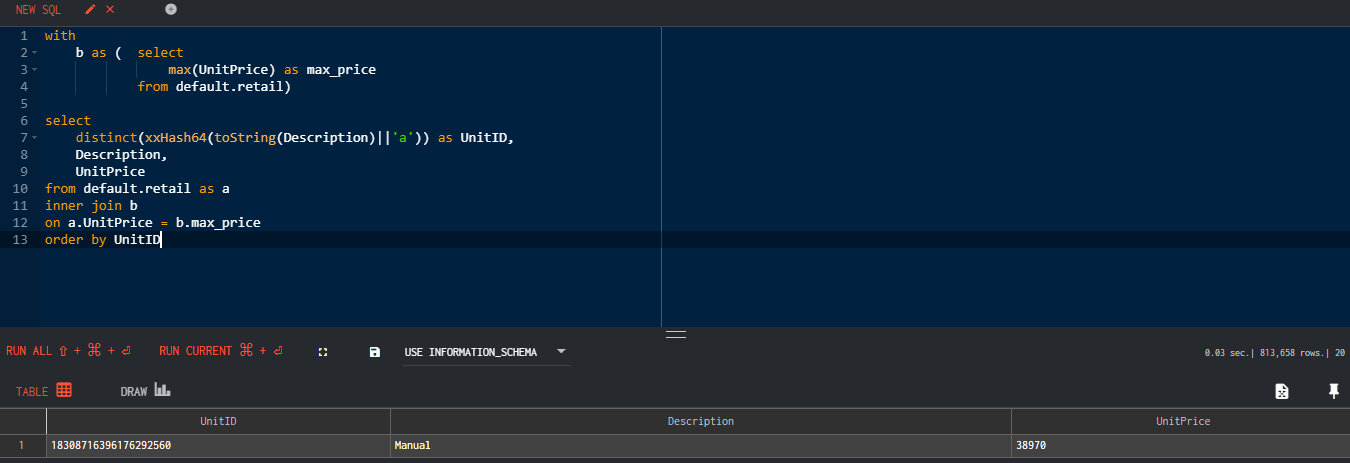

## Задача 4

In [7]:
q = '''
select 
    argMax(Country, ID),
    Max(ID)
from
(select
    Country,
    uniqExact(CustomerID) as ID
from default.retail
group by Country)
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,"argMax(Country, ID)",max(ID)
0,United Kingdom,3950


# Таблица simulator.feed_actions

Это про действия пользователя в социальной сети, где есть Лента новостей, в которой можно совершать просмотры постов (событие view) и ставить им лайки ( событие like)

* user_id – id пользователя
* post_id – id поста
* action – действие (просмотр или лайк)
* time – дата-время события
* gender – пол
* age – возраст
* country – Страна
* city – Город
* os – Операционная система
* source – Источник трафика (откуда пользователь к нам пришел, например, "через рекламу", "сам по себе" и тд
* exp_group – экспериментальная группа (на пользователях могут проводить эксперименты, например показывать кому-то другой алгоритм рекомендаций постов)

# simulator.posts_text

* post_id – id поста
* text – текст поста
* topic – тема поста (политика, развлечения, кино)

## Задача 5

На занятии мы с вами пытались ответить на вопрос, какие посты (в зависимости от темы) набирают больше просмотров: длинные или короткие.

Измените запрос таким образом, чтобы проанализировать зависимость кол-ва просмотров от длины текста поста вне зависимости от темы. Запрос с лекции приведен ниже

In [9]:
q ='''
select 
    case when text_len <= quantile_10_len then 1
         when text_len <= quantile_20_len then 2
         when text_len <= quantile_30_len then 3
         when text_len <= quantile_40_len then 4
         when text_len <= quantile_50_len then 5
         when text_len <= quantile_60_len then 6
         when text_len <= quantile_70_len then 7
         when text_len <= quantile_80_len then 8
         when text_len <= quantile_90_len then 9
    else 10 end as length_bucket,
    avg(views) as avg_views
    
from (select replaceRegexpAll(texts.topic, '\w+', 'topic') as topic,
        length(text) as text_len,
        post_data.post_id as post_id,
        post_data.views as views,
        post_data.likes as likes
    from simulator.posts_text as texts
    left join 
        (select post_id,
            countIf(action = 'view') as views,
            countIf(action = 'like') as likes
        from simulator.feed_actions
        group by post_id) as post_data
    on texts.post_id = post_data.post_id) as views_data
left join 
    (select replaceRegexpAll(topic, '\w+', 'topic') as topic,
        min(length(text)) as min_len,
        quantileExact(0.1)(length(text)) as quantile_10_len,
        quantileExact(0.2)(length(text)) as quantile_20_len,
        quantileExact(0.3)(length(text)) as quantile_30_len,
        quantileExact(0.4)(length(text)) as quantile_40_len,
        quantileExact(0.5)(length(text)) as quantile_50_len,
        quantileExact(0.6)(length(text)) as quantile_60_len,
        quantileExact(0.7)(length(text)) as quantile_70_len,
        quantileExact(0.8)(length(text)) as quantile_80_len,
        quantileExact(0.9)(length(text)) as quantile_90_len,
        max(length(text)) as max_len
    from simulator.posts_text
    group by topic) as quantile_data
using topic
group by topic, length_bucket
order by topic, length_bucket
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,length_bucket,avg_views
0,1,7790.664921
1,2,8531.232394
2,3,9525.436019
3,4,9936.159091
4,5,9156.594864
5,6,7585.823613
6,7,6272.263533
7,8,6270.386040
8,9,6144.135328
9,10,6332.132479


## Задача 6

Посты с какой тематикой являются самыми просматриваемыми?

In [10]:
q ='''
select
    argMax(topic, avg_views) as top_topic,
    max(avg_views) as max_avg_views
from(
select 
    topic,
    avg(views) as avg_views
from(
select texts.topic as topic,
        post_data.post_id as post_id,
        post_data.views as views,
        post_data.likes as likes
    from simulator.posts_text as texts
    left join 
        (select post_id,
            countIf(action = 'view') as views,
            countIf(action = 'like') as likes
        from simulator.feed_actions
        group by post_id) as post_data
    on texts.post_id = post_data.post_id
    )
group by topic
    )
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,top_topic,max_avg_views
0,movie,9522.514333


## Задача 7

На сколько символов в среднем длиннее посты про политику чем посты про спорт?

In [11]:
q ='''
select round(sum(avg_text_len), 0) as politics_minus_sport
from(
select 
    topic,
    case when topic = 'sport' then avg(text_len) * -1
        else avg(text_len) end as avg_text_len
from(
select texts.topic as topic,
        length(text) as text_len,
        post_data.post_id as post_id,
        post_data.views as views,
        post_data.likes as likes
    from simulator.posts_text as texts
    left join 
        (select post_id,
            countIf(action = 'view') as views,
            countIf(action = 'like') as likes
        from simulator.feed_actions
        group by post_id) as post_data
    on texts.post_id = post_data.post_id
    )
where topic in ('sport', 'politics')
group by topic
    )
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,politics_minus_sport
0,784.0


## Задача 8

Постройте график конверсии из просмотров в лайки по постам про кино и про бизнес по дням. Можно ли "на глаз" сказать, что эти конверсии отличаются?

(построить суммарное кол-во лайков/суммарное кол-во просмотров where тема бизнес или кино group by день, тема)

In [12]:
q ='''
select
    topic,
    dt,
    sum(likes)/sum(views) as ctr
from(
select
    text.topic as topic,
    toDate(time) as dt,
    post_id,
    countIf(action = 'view') as views,
    countIf(action = 'like') as likes
from simulator.feed_actions as action
left join
    simulator.posts_text as text
using post_id
where topic in ('movie', 'business')
group by topic, dt, post_id
    )
group by topic, dt
order by dt
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,topic,dt,ctr
0,business,2021-10-19,0.229045
1,business,2021-10-20,0.218451
2,business,2021-10-21,0.215571
3,business,2021-10-22,0.215911
4,business,2021-10-23,0.208859
5,business,2021-10-24,0.201676
6,business,2021-10-25,0.194110
7,business,2021-10-26,0.196691
8,business,2021-10-27,0.197394
9,business,2021-10-28,0.198224


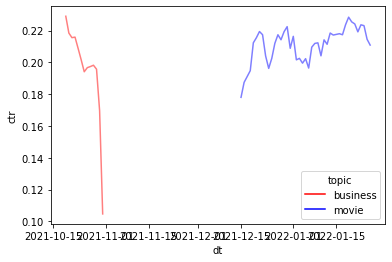

In [13]:
groups = sns.lineplot(data = df, 
                      x='dt', 
                      y = 'ctr',
                      hue='topic', 
                      palette = ['r', 'b'],
                      alpha=0.5)

# Если не учитывать спад CTR по теме 'business' в последний день, то на глаз определитть разницу нельзя.

# Задача 9

Похоже ли разбиение на группы на равномерное. Проверить каким-нибудь тестом (например хи-квадрат)

In [3]:
q ='''
with (select  
        uniqExact(user_id)
        from simulator.feed_actions) as users

select sum(stat_value) as stat
from(
select 
    exp_group,
    uniqExact(user_id) as obs,
    users/5 as expect,
    pow(obs - expect, 2) / (users * expect) as stat_value
from simulator.feed_actions
group by exp_group
    )
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df

,stat
0,0.00001


In [9]:
T = df.loc[0][0]
test = T < stats.chi2.ppf(0.95, df=4)
print('Гипотеза о равномерности разбиения групп {}.'.format('отвергается' if test == False else 'не отвергается'))

Гипотеза о равномерности разбиения групп не отвергается.


In [10]:
1 - stats.chi2.cdf(T, df=4)

0.9999999999863679